In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Unconditional Pixel Diffusion Training

In this notebook, we will train a simple `PixelDiffusion` model in low resolution (64 by 64).

The training should take about 10 hours.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
!rm maps.tar.gz
```

Ideally, you will download this dataset once and store it as `data/maps`. If you're running on colab, it's a good idea to download it once to your personal machine (it's only 240 MB) and then upload it to your colab space when you start a new notebook.

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import lightning as L

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from precipitation.models.diffusion.lightning_pixel_diffusion import PixelDiffusion

mpl.rcParams['figure.figsize'] = (8, 8)

/home/gregor/anaconda3/envs/precip_2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg']        
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

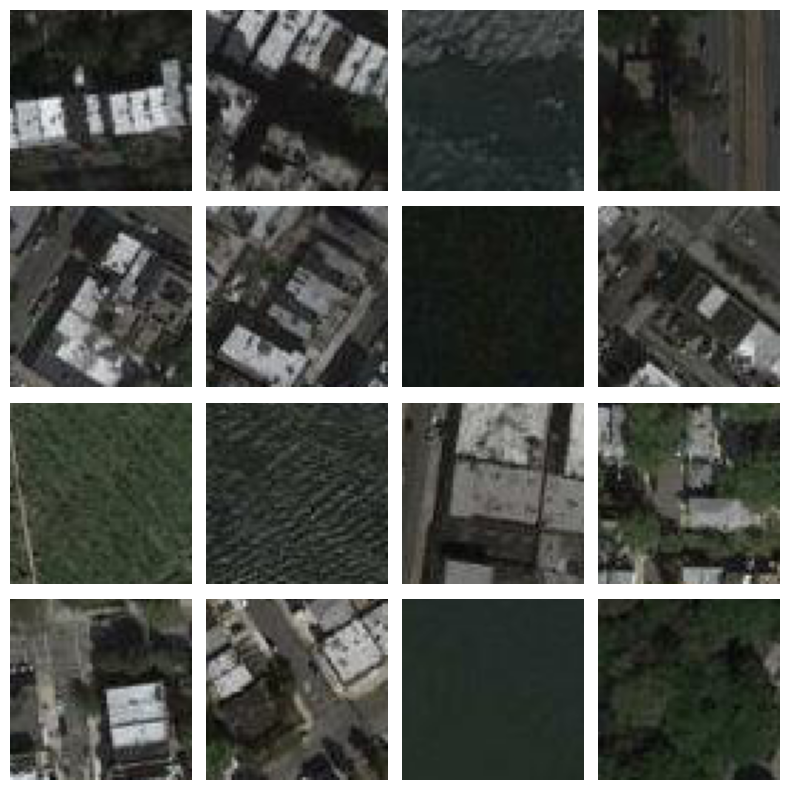

In [4]:
CROP_SIZE=64

inp_T=[        
        KA.RandomCrop((CROP_SIZE,CROP_SIZE)),
    ]

train_ds=SimpleImageDataset('/home/gregor/datasets/maps/train',
                            transforms=inp_T
                     )

val_ds=SimpleImageDataset('/home/gregor/datasets/maps/val',
                           transforms=inp_T
                          )

for idx in range(16):
    plt.subplot(4,4,1+idx)
    plt.imshow(train_ds[idx].permute(1,2,0))
    plt.axis('off')
plt.tight_layout()

### Model Training

In [5]:
model=PixelDiffusion(train_ds,
                     val_ds,
                     lr=1e-4,
                     batch_size=16)

Is Time embed used ?  True


In [6]:
# compiled_model = torch.compile(model)

In [7]:
from lightning.pytorch.callbacks import StochasticWeightAveraging


class EMACallback(StochasticWeightAveraging):
    def __init__(self, swa_lrs=1.e-4, decay=0.9999):
        super().__init__(swa_lrs)
        self.decay=decay
    
    def avg_fn(averaged_model_parameter: torch.Tensor, model_parameter: torch.Tensor, num_averaged: torch.LongTensor) -> torch.FloatTensor:
        return averaged_model_parameter * self.decay + (1. - self.decay) * model

In [8]:
trainer = L.Trainer(
    precision=16,
    max_steps=10000,
    callbacks=[EMACallback(0.9999)],
    devices = [1]
)

/home/gregor/anaconda3/envs/precip_2.0/lib/python3.10/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
# trainer.fit(compiled_model)
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params
----------------------------------------------------
0 | model | DenoisingDiffusionProcess | 56.6 M
----------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.463   Total estimated model params size (MB)


Epoch 144:  93%|█████████▎| 64/69 [00:05<00:00, 12.42it/s, v_num=6]        

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 144:  93%|█████████▎| 64/69 [00:06<00:00, 10.50it/s, v_num=6]


In [10]:
B=8 # number of samples

model.cuda()
out=model(batch_size=B,shape=(64,64),verbose=True)

diffusion sampling: 100%|██████████| 1000/1000 [00:18<00:00, 53.47it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


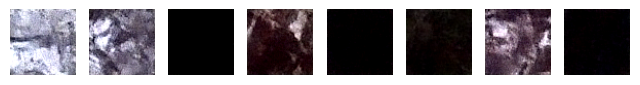

In [11]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
B=8 # number of samples
STEPS=200 # ddim steps

from precipitation.models.diffusion.samplers import DDIM_Sampler

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_size=B,sampler=ddim_sampler,shape=(64,64),verbose=True)

In [ ]:
for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')